In [1]:
import seaborn as sns
import shap
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from scipy.stats import kendalltau, pearsonr
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

sys.path.insert(1, '/home/guilherme-resende/Desktop/mono2/utils')
import qif

In [2]:
sns.set()

In [3]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv("../data/synthetic_dataset.csv")

In [5]:
df.tail(3)

,f0,f1,f2,f3,f4,target
2997,2,5,0,5,0,1
2998,0,3,4,2,1,0
2999,0,4,2,3,4,0


Divides synthetic data into train and test

In [6]:
train_idx = df.sample(frac=0.8).index
test_idx = df[~df.index.isin(train_idx)].index

X_train = df.iloc[train_idx].drop("target", axis=1)
Y_train = df.loc[train_idx, "target"]

X_test = df.iloc[test_idx].drop("target", axis=1)
Y_test = df.loc[test_idx, "target"]

In [7]:
df_test = df.iloc[test_idx]

In [8]:
xgb = XGBClassifier()

Fit and Predict with the model

In [9]:
xgb.fit(X_train, Y_train)
preds = xgb.predict(X_test)
preds_proba = xgb.predict_proba(X_test)[:, 1:]

df_test.loc[:, "preds_proba"] = preds_proba.reshape(-1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


As expected, the model was always able to predict the correct label.

In [10]:
print(f"F1_Score is {f1_score(Y_test, preds)}, whereas AUC is {roc_auc_score(Y_test, preds_proba)}")

F1_Score is 1.0, whereas AUC is 1.0


### QIF

In [11]:
# Discretize the probabilities
df_test["preds_proba"] = (df_test["preds_proba"] * 100).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
bayes_leakage = qif.BayesLeakage(df_test)
feature_names = X_test.columns

In [13]:
qif_values = []
for feature in feature_names:
    leakage = bayes_leakage.compute_flows(x=feature, y='preds_proba')
    qif_values.append(max(leakage))

qif_values = np.array(qif_values)
qif_values = qif_values / qif_values.sum() # Normalize

That's a shit

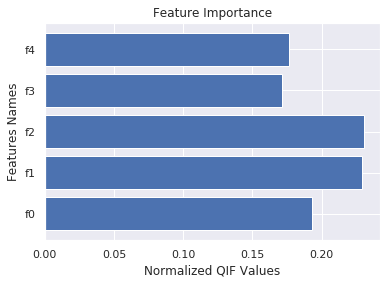

In [14]:
plt.barh(feature_names, qif_values)
plt.title("Feature Importance")
plt.ylabel("Features Names")
plt.xlabel("Normalized QIF Values")
plt.show()

Since the a priori data follows a binary uniform distribution, it falls right into a weak spot of QIF. It considers a priori and a posteriori distribuitions, hence, equally distributed probabilities doesn't add much to the analysis when theres few classes (e.g {1,2}) in the feature column.

Possible experiments:
    - Consider more classes for each feature
    - Build a more complex target variable
    - Analyze QIF's coeficients behavior as the number of classes in the important features increases

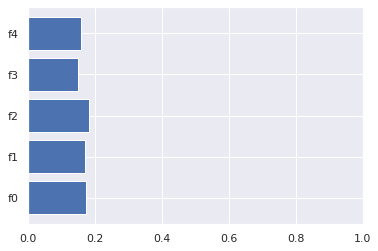

In [15]:
df_test = df_test.drop(["preds_proba", "target"], axis=1)
x = [df_test.loc[df_test[col]==1, col].count() for col in df_test.columns]
x = np.array(x) / df_test.shape[0]

plt.barh(df_test.columns, x)
plt.xlim(right=1)
plt.show()

### SHAP

In [16]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test.values)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [17]:
shap_values

array([[ 0.0000000e+00, -3.3005471e+00,  1.7906653e+00, -6.1332178e-04,
         0.0000000e+00],
       [ 0.0000000e+00, -3.3017607e+00,  1.7906653e+00,  6.0027925e-04,
         0.0000000e+00],
       [ 0.0000000e+00,  1.9763675e+00, -3.4094162e+00,  2.0477267e-03,
         0.0000000e+00],
       ...,
       [ 0.0000000e+00, -1.2653908e+00, -1.2430354e+00, -6.1332178e-04,
         0.0000000e+00],
       [ 0.0000000e+00,  1.9746547e+00, -3.4094162e+00, -2.0922183e-03,
         0.0000000e+00],
       [ 0.0000000e+00, -1.2666043e+00, -1.2430354e+00,  6.0027925e-04,
         0.0000000e+00]], dtype=float32)

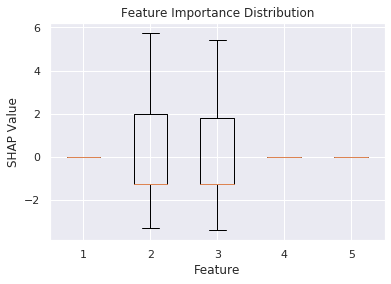

In [18]:
plt.boxplot(shap_values)
plt.title("Feature Importance Distribution")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.show()

In [23]:
shap_values = shap_values.mean(axis=0)

In [24]:
k_coef, _ = kendalltau(shap_values, qif_values)
p_coef, _ = pearsonr(shap_values, qif_values)

In [25]:
print("Kendall:", k_coef)
print("Pearson:", p_coef)

Kendall: -0.5270462766947299
Pearson: -0.9049430628407273


In [27]:
shap_values

array([ 0.0000000e+00, -1.8984427e-01, -3.4687483e-01, -1.5480091e-05,
        0.0000000e+00], dtype=float32)